In [1]:
"""Delete ths cell when done!"""
%load_ext autoreload
%autoreload complete

# **run load_data.ipynb BEFORE running this!**

In [2]:
import numpy as np
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
s = {
    'problem'           : "regression",
    'approach'          : "metric learning/non-parametric",
    'algorithm'         : "triplet network",
    'input'             : "samples from a distribution",
    'input type'        : "vectors",
    'input meaning'     : "spectrum", 
    'output'            : "samples from a distribution",
    'output type'       : "one number",
    'output meaning'    : "temperature or pressure, depending on distribution",
    'learning rate'     : 1e-4,
    'input dimension'   : 10000,
    'output dimension'  : 1,
    'feature dimension' : 300,
    'epoch'             : 1000,
    'epoch-development' : 1,
    'cross validation round': 16,
    'cross validation round-development' : 1,
    'batch size'        : 64,
    'best model folder' : 'triplet_best_model/'
}
# https://arxiv.org/pdf/1412.6622.pdf
import data_accessor as acc
data_names_list = [
    'temperature_230509_discrete',
    'pressure_230516_discrete'
    ]
data_dictionary = acc.setup(data_names_list)

loading temperature_230509_discrete__________________________
	input shape (number, dimension): (6000, 10000)
	label shape (number, dimension): (6000, 1)
	there are 16 folds
	4200 for training, 600 for validating, 1200 for testing
loading pressure_230516_discrete__________________________
	input shape (number, dimension): (5000, 10000)
	label shape (number, dimension): (5000, 1)
	there are 16 folds
	3500 for training, 500 for validating, 1000 for testing


In [3]:
import torch.nn as nn
class TripletNetwork(torch.nn.Module):
    """ Input: pos, neg, anchor, anchor_label
        Output: pos_prediction, neg_prediction"""
    def __init__(self, device, input_dimension, feature_dimension, output_dimension):
        super().__init__()
        self.input_dimension = input_dimension
        self.feature_dimension = feature_dimension
        self.output_dimension = output_dimension
        self.device = device
        self.feature_sequential = torch.nn.Sequential(
            torch.nn.Linear(self.input_dimension, 3000),
            nn.ReLU(),
            torch.nn.Linear(3000, 600),
            nn.ReLU(),
            torch.nn.Linear(600, 600),
            nn.ReLU(),
            torch.nn.Linear(600, 300),
            nn.ReLU(),
            torch.nn.Linear(300, self.feature_dimension)
        )
        self.auxiliary_sequential = torch.nn.Sequential(
            torch.nn.Linear(self.feature_dimension, 100),
            nn.ReLU(),
            torch.nn.Linear(100, 100),
            nn.ReLU(),
            torch.nn.Linear(100, self.output_dimension)
        )
        self.to(device)
        self.float()
    def forward(self, pos, neg, anchor, anchor_label):
        feature_pos = self.feature_sequential(pos)
        feature_neg = self.feature_sequential(neg)
        feature_anchor = self.feature_sequential(anchor)
        feature_space_difference_pos_anchor = feature_pos - feature_anchor
        feature_space_difference_neg_anchor = feature_neg - feature_anchor
        label_space_difference_pos_anchor = self.auxiliary_sequential(feature_space_difference_pos_anchor)
        label_space_difference_neg_anchor = self.auxiliary_sequential(feature_space_difference_neg_anchor)
        prediction_pos = anchor_label + label_space_difference_pos_anchor
        prediction_neg = anchor_label + label_space_difference_neg_anchor
        return prediction_pos, prediction_neg

In [4]:
from tools import SaveBestModel, PatienceEarlyStopping, Scheduler, plot_losses
class Manager:
    """ DOES: train & evaluate a Siamese network
        """
    def __init__(self, epoch, cross_validation_round):
        self._network = TripletNetwork(device, s['input dimension'], s['feature dimension'], s['output dimension'])
        self._network.apply(self.initializer)
        self._learning_rate = s['learning rate']
        self._optimizer = torch.optim.Adam(
            params=self._network.parameters(), lr=self._learning_rate,
            weight_decay=3e-3)
        self._energy = nn.MSELoss()
        self._train_loss = []
        self._valid_loss = []
        self._test_loss = []
        self._epoch = epoch
        self._stopper = PatienceEarlyStopping(patience=5, min_delta=5e-7)
        self._cross_validation_round = cross_validation_round
        self._saver = SaveBestModel(s['best model folder'])
        self._scheduler = Scheduler(optimizer=self._optimizer, 
            minimum_learning_rate=1e-6, patience=5, factor=0.5)
    def initializer(self, layer):
        if type(layer) == nn.Linear:
            nn.init.kaiming_normal_(layer.weight) # normal version
    def _step(self, job):
        pos, pos_label, neg, neg_label, anchor, anchor_label = job
        pos_prediction, neg_prediction = self._network(pos, neg, anchor, anchor_label)
        pos_loss = self._energy(pos_prediction, pos_label)
        neg_loss = self._energy(neg_prediction, neg_label)
        loss = (pos_loss + neg_loss) / 2.0
        return loss     
    def train(self, train_dataloader, valid_dataloader):
        """ DOES: calculate loss from tasks
            NOTE: we have a BATCH of tasks here """
        for e in range(self._epoch):
            batch_train_loss = []
            for _, batch in enumerate(train_dataloader): 
                self._optimizer.zero_grad()
                loss = self._step(batch)
                loss.backward()
                self._optimizer.step()
                batch_train_loss.append(loss.item())
            self._train_loss.append(np.mean(batch_train_loss))
            batch_valid_loss = []
            with torch.no_grad():
                for _, batch in enumerate(valid_dataloader): 
                    loss = self._step(batch)
                    batch_valid_loss.append(loss.item())
            self._valid_loss.append(np.mean(batch_valid_loss))
            # saving, early stopping, scheduler for EACH epoch!
            self._saver(current_loss=np.mean(batch_valid_loss), model=self._network, round=self._cross_validation_round)
            self._scheduler(np.mean(batch_valid_loss))
            self._stopper(np.mean(batch_valid_loss))
            if self._stopper.early_stop == True:
                print(f"EARLY STOPPING @ epoch {e}")
                break
        # summary printout, after we're done with epochs
        print(f"min train loss: {np.min(self._train_loss)}")
        print(f"min valid loss: {np.min(self._valid_loss)}")
        plot_losses(self._train_loss, self._valid_loss, self._cross_validation_round)
        return np.min(self._valid_loss)
    def test(self, test_dataloader):
        with torch.no_grad():
            batch_test_loss = []
            for _, batch in enumerate(test_dataloader): 
                loss = self._step(batch)
                batch_test_loss.append(loss.item())
            self._test_loss.append(np.mean(batch_test_loss)) 
        return np.min(self._test_loss)
    def reset_for_sequential(self):
        self._saver.reset()
        self._stopper.reset()
        self._train_loss = []
        self._valid_loss = []
        # self._scheduler = Scheduler(optimizer=self._optimizer, 
        #     minimum_learning_rate=1e-6, patience=5, factor=0.5)
        # self._learning_rate = s['learning rate']
        # self._optimizer = torch.optim.Adam(
        #     params=self._network.parameters(), lr=self._learning_rate,
        #     weight_decay=3e-3)
        # memory-wipe for auxiliary network
        # self._network.auxiliary_sequential.apply(self.initializer)

In [5]:
import random
class TripletDataset(torch.utils.data.TensorDataset):
    """ input: input data
        label: label
        indices: indices used e.g. training indices
        """
    def __init__(self, input, label, indices, device):
        self.input = torch.Tensor(input).to(device)
        self.label = torch.Tensor(label).to(device)
        self.access_indices = indices
        self.indices = range(len(self.access_indices))
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, index): 
        index = self.access_indices[index]
        anchor_index = random.choice(self.access_indices)
        neg_index = random.choice(self.access_indices)
        pos = self.input[index]
        pos_label = self.label[index]
        anchor = self.input[anchor_index]
        anchor_label = self.label[anchor_index]
        neg = self.input[neg_index]
        neg_label = self.label[neg_index]
        return pos, pos_label, neg, neg_label, anchor, anchor_label

__________CROSS VALIDATION__________
Cross-validation rounds: 16
Epochs: 1000
Datas to learn: 
	0: temperature_230509_discrete
	1: pressure_230516_discrete
MULTI TASK, Sequential____________________________
we're learning: multiple tasks
given [1, 2, 3], [a, b, c]: learn [1, 2, 3], reset model, learn [a, b, c]
>round 0
task 0: temperature_230509_discrete
EARLY STOPPING @ epoch 21
min train loss: 0.00010126053359382433
min valid loss: 9.67653228144627e-05


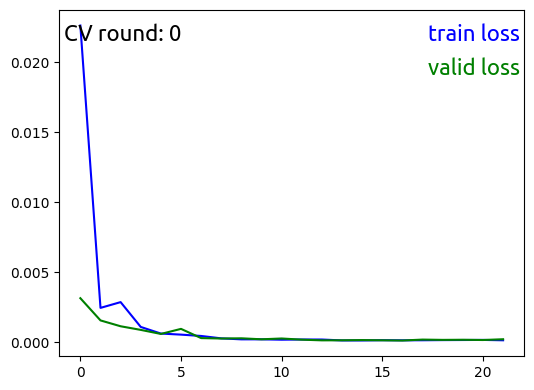

task 1: pressure_230516_discrete
EARLY STOPPING @ epoch 27
min train loss: 0.0002887918780536645
min valid loss: 0.0002971733956655953


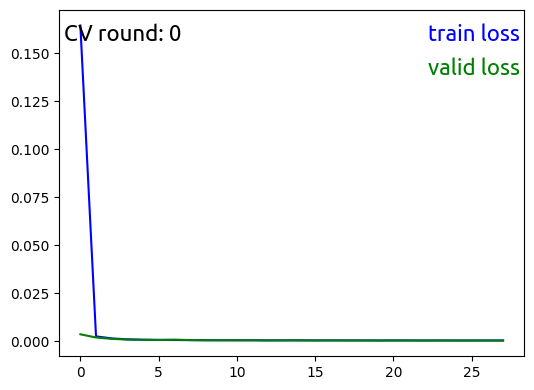

>round 1
task 0: temperature_230509_discrete


KeyboardInterrupt: 

In [6]:
from torch.utils.data import DataLoader
from tools import SaveBestCrossValidationModel
from Style import TextColor
class CrossValidator:
    """ number_of_cross_validation_rounds
        \nnumber_of_epochs
        \nsaver (actual object)
        \ndataset (the function of the object)
        """
    def __init__(self, number_of_cross_validation_rounds, number_of_epochs, saver, dataset, datas, data_dictionary, settings):
        self.number_of_cross_validation_rounds = number_of_cross_validation_rounds
        self.number_of_epochs = number_of_epochs
        self.saver = saver
        self.cross_validation_loss = []
        self.dataset = dataset
        self.datas = datas
        self.data_dictionary = data_dictionary
        self.settings = settings
        print(f"{TextColor.Bold}{TextColor.BrightGreen_text}__________CROSS VALIDATION__________{TextColor.End}")
        print(f"Cross-validation rounds: {self.number_of_cross_validation_rounds}")
        print(f"Epochs: {self.number_of_epochs}")
        print(f"Datas to learn: ")
        for index, data in enumerate(self.datas):
            print(f"\t{index}: {data}")
    def complete_notify(self):
        # unicode https://www.geeksforgeeks.org/python-program-to-print-emojis/
        print(f"\U0001f607 {TextColor.Bold}{TextColor.BrightGreen_text}TRAINing COMPLETE____________________________{TextColor.End}")
    def single_task_train(self, data_index): # magenta
        print(f"{TextColor.Bold}{TextColor.Magenta_text}SINGLE TASK____________________________{TextColor.End}")
        print(f"we're learning: {self.datas[data_index]}")
        self.cross_validation_loss = []
        for round_index in range(self.number_of_cross_validation_rounds):
            print(f">round {round_index}")
            network_object = Manager(self.number_of_epochs, round_index)
            valid_loss = network_object.train( # DON'T do so in separate function
                DataLoader(self.dataset(
                self.data_dictionary[self.datas[data_index]]['data'],
                self.data_dictionary[self.datas[data_index]]['label'],
                self.data_dictionary[self.datas[data_index]]['train indices'][round_index],
                device=device,), shuffle=False, batch_size=self.settings['batch size']),
                DataLoader(self.dataset(
                self.data_dictionary[self.datas[data_index]]['data'],
                self.data_dictionary[self.datas[data_index]]['label'],
                self.data_dictionary[self.datas[data_index]]['valid indices'][round_index],
                device=device,), shuffle=False, batch_size=self.settings['batch size']))
            self.saver(current_loss=valid_loss, round=round_index)
            self.cross_validation_loss.append(valid_loss)
        print(f"{TextColor.Bold}{TextColor.BrightGreen_text}BEST{TextColor.End} model: {self.saver.best_model_name} with {self.saver.current_best_loss}")
        print(f"trained on {self.datas[data_index]}")
        print(f"Aggregate performance: Valid loss mean {np.mean(self.cross_validation_loss)}, std {np.std(self.cross_validation_loss)}")
    def multi_task_train_sequential(self): # blue
        """ learn ONE data at a time, need to reset model in between"""
        print(f"{TextColor.Bold}{TextColor.Blue_text}MULTI TASK, Sequential____________________________{TextColor.End}")
        print(f"we're learning: multiple tasks")
        print(f"given [1, 2, 3], [a, b, c]: learn [1, 2, 3], reset model, learn [a, b, c]")
        # for number, data in enumerate(self.datas):
        #     print(f"\t{number}: {data}")
        self.cross_validation_loss = [[] for data in datas]
        # print(self.cross_validation_loss)
        for round_index in range(self.number_of_cross_validation_rounds):
            print(f">round {round_index}")
            network_object = Manager(self.number_of_epochs, round_index)
            for number, data in enumerate(self.datas):
                print(f"task {TextColor.Bold}{number}{TextColor.End}: {data}")
                valid_loss = network_object.train( # DON'T do so in separate function
                    DataLoader(self.dataset(
                    self.data_dictionary[data]['data'],
                    self.data_dictionary[data]['label'],
                    self.data_dictionary[data]['train indices'][round_index],
                    device=device,), shuffle=False, batch_size=self.settings['batch size']),
                    DataLoader(self.dataset(
                    self.data_dictionary[data]['data'],
                    self.data_dictionary[data]['label'],
                    self.data_dictionary[data]['valid indices'][round_index],
                    device=device,), shuffle=False, batch_size=self.settings['batch size']))
                network_object.reset_for_sequential()
                self.cross_validation_loss[number].append(valid_loss)
            # picking best model by Current performance
            self.saver(current_loss=valid_loss, round=round_index)
        # print(self.cross_validation_loss)
        print(f"{TextColor.Bold}{TextColor.BrightGreen_text}BEST{TextColor.End} model: {self.saver.best_model_name} with {self.saver.current_best_loss}")
        print(f"trained datas sequentially")
        print(f"Aggregate performance:")
        for index, cv_loss in enumerate(self.cross_validation_loss):
            print(f"{self.datas[index]}: Valid loss mean {np.mean(self.cross_validation_loss[index])}, std {np.std(self.cross_validation_loss[index])}")
    def multi_task_train_weave(self, weave): # blue
        """ learn altogether, using 'super dataset' woven from datasets
            weave: function for weaving"""
        print(f"\U0001f9f5{TextColor.Bold}{TextColor.Magenta_text}MULTI TASK, Interweave____________________________{TextColor.End}")
        print(f"we're learning: multiple tasks")
        print(f"given [1, 2, 3], [a, b, c]: learn [1, a, 2, b, 3, c], simple handling of different counts")
        # for number, data in enumerate(self.datas):
        #     print(f"\t{number}: {data}")
        self.cross_validation_loss = []
        for round_index in range(self.number_of_cross_validation_rounds):
            print(f">round {round_index}")
            network_object = Manager(self.number_of_epochs, round_index)
            # t = weave([data_dictionary[data]['data'][data_dictionary[data]['train indices'][round_index]] for data in datas])
            # print(f"shape of woven: {t.shape}")
            # i = sum([len(data_dictionary[data]['train indices'][0]) for data in datas])
            # print(f"length of woven: {i}")
            valid_loss = network_object.train( # DON'T do so in separate function
                DataLoader(self.dataset(
                weave([self.data_dictionary[data]['data'][self.data_dictionary[data]['train indices'][round_index]] for data in self.datas]),
                weave([self.data_dictionary[data]['label'][self.data_dictionary[data]['train indices'][round_index]] for data in self.datas]),
                range(sum([len(self.data_dictionary[data]['train indices'][0]) for data in self.datas])),
                device=device,), shuffle=False, batch_size=self.settings['batch size']),
                DataLoader(self.dataset(
                weave([self.data_dictionary[data]['data'][data_dictionary[data]['valid indices'][round_index]] for data in self.datas]),
                weave([self.data_dictionary[data]['label'][data_dictionary[data]['valid indices'][round_index]] for data in self.datas]),                    
                range(sum([len(self.data_dictionary[data]['valid indices'][0]) for data in self.datas])),
                device=device,), shuffle=False, batch_size=self.settings['batch size']))    
            self.saver(current_loss=valid_loss, round=round_index)
            self.cross_validation_loss.append(valid_loss)
        print(f"{TextColor.Bold}{TextColor.BrightGreen_text}BEST{TextColor.End} model: {self.saver.best_model_name} with {self.saver.current_best_loss}")
        print(f"trained datas by weaving them")
        print(f"Aggregate performance: Valid loss mean {np.mean(self.cross_validation_loss)}, std {np.std(self.cross_validation_loss)}")
    def test_all(self):
        """ test data one by one"""
        print(f"{TextColor.Bold}{TextColor.Blue_text}TEST____________________________{TextColor.End}")
        retained_loss = {}
        for data in self.datas:
            network_object = Manager(None, None)
            network_object._network.load_state_dict(torch.load(self.settings['best model folder'] + self.saver.best_model_name))
            print(f"Testing {data}, loss: ", end=" ")
            # print(f"shape: {np.asarray(self.data_dictionary[data]['label'])[0:4]}")
            test_loss = network_object.test(
                DataLoader(self.dataset(
                self.data_dictionary[data]['data'],
                self.data_dictionary[data]['label'],
                self.data_dictionary[data]['test indices'],
                device=device,), shuffle=False, batch_size=self.settings['batch size']))
            # record results
            retained_loss[data] = test_loss
            print(f"{test_loss}")
            # print(f"{data} Test loss: {test_loss}")

datas = ['temperature_230509_discrete', 'pressure_230516_discrete']
# datas.reverse()
CVtor = CrossValidator(s['cross validation round'], 
                       s['epoch'], 
                       SaveBestCrossValidationModel(s['best model folder']), 
                       TripletDataset,
                       datas,
                       data_dictionary,
                       s)
# CVtor.single_task_train(0)
CVtor.multi_task_train_sequential()
from data import alternate_rows_itertools
# CVtor.multi_task_train_weave(alternate_rows_itertools) 
CVtor.complete_notify()
CVtor.test_all()
# from IPython.display import Audio # auto-play doesn't work!
# sound_file = 'sound/IRWTS@UH.mp3'
# aud = Audio(sound_file, autoplay=True)
# display(aud)